# Visualizing data with Python + R/ggplot2

In [1]:
# On Azure Notebooks, you need to manually install this Python package first
!pip install tzlocal

In [41]:
import pandas
import numpy as np

# Start an embedded R session, hosted by Python/Jupyter.
# Then load in some R plotting libraries.
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(ggthemes)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['data.table', 'ggthemes', 'ggplot2', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U10')

In Jupyter, a line that starts `%R` means "this line is to be run in R". It accepts optional arguments. So, for example,
```
%R library(ggplot2)
%R -i housing
```
means "first execute the R command `library(ggplot2)` in the embedded R session, then copy the pandas DataFrame `housing` into R (and run no command)."

A cell that starts `%%R` means "the entire contents of this cell are to be run in R". It also accepts command-line arguments, for example
```
%%R -w12 -h7 -uin
```
means "Run the following lines in the embedded R session, and let any graphical output be rendered into 12x7 inches then displayed in Jupyter." 

In [5]:
URL = 'https://raw.githubusercontent.com/marekrei/cl-datasci-pnp/master/DSPNP_practical1/housing/housing.csv'
housing = pandas.read_csv(URL)

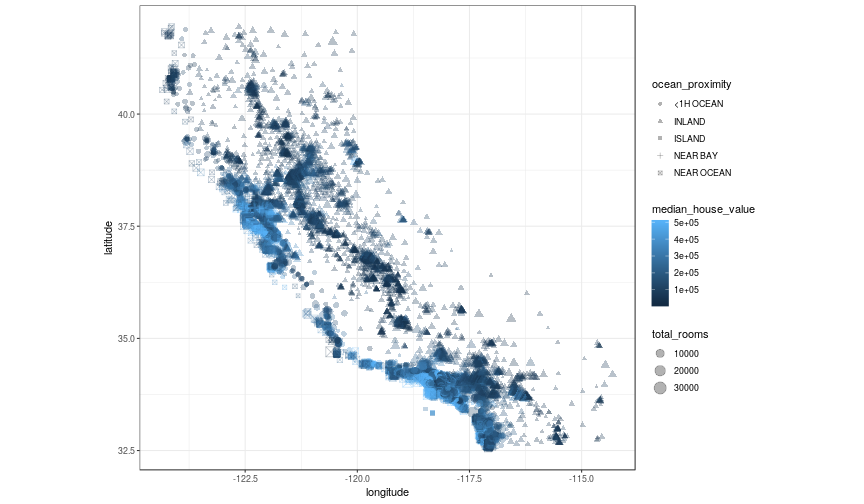

In [6]:
%%R -w12 -h7 -uin -i housing

ggplot(data=housing) + 
    geom_point(aes(x=longitude, y=latitude, size=total_rooms, col=median_house_value, shape=ocean_proximity), alpha=.3) +
    coord_fixed() +
    theme_bw()

# 0. Some bar charts and line plots

In [19]:
url = 'https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/lecture1-introduction/data/country-stats.csv'
country = pandas.read_csv(url)

df = country.copy()
df['unemployment'] = np.where(df['Unemployment, Total (%)']<7, 'low', 'high')
df = df.groupby('unemployment')['GDP per Capita (PPP USD)'].apply(np.mean)
df = df.to_frame().reset_index()
df.rename(columns={'GDP per Capita (PPP USD)':'gdp_per_capita'}, inplace=True)

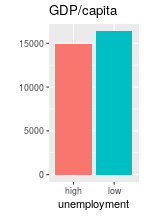

In [21]:
%%R -w2 -h3 -uin -i df

ggplot(data=df) +
    geom_bar(aes(x=unemployment, y=gdp_per_capita, fill=unemployment), stat='identity') +
    scale_fill_discrete(guide=FALSE) +
    ylab('') + ggtitle('GDP/capita')

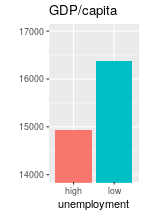

In [22]:
%%R -w2 -h3 -uin -i df

ggplot(data=df) +
    geom_bar(aes(x=unemployment, y=gdp_per_capita, fill=unemployment), stat='identity') +
    scale_fill_discrete(guide=FALSE) +
    coord_cartesian(ylim=c(14000,17000)) +
    ylab('') + ggtitle('GDP/capita')

In [31]:
url = 'https://teachingfiles.blob.core.windows.net/datasets/climate.csv'
climate = pandas.read_csv(url)
climate['temp'] = (climate.tmin + climate.tmax) / 2
climate = climate[['yyyy','mm','temp','station']]

In [38]:
import sklearn.linear_model

# Want: average temperature each decade, averaged over the months.
# I won't assume the response is sinusoidal: I'll allow an arbitrary shape
# over the months,
#     temp ~ α_decade + β_month
# This model has too many parameters.
# I could (1) use it as is, or discard an arbitrary parameter, and then
# do post-processing on the coefficients in order to derive the average
# temperature in each decade, which would involve adding up per-month
# coefficients and then taking the mean; or I could (2) come up with
# a different parameterization of the month terms, so that α_decade truly
# is the average temperature that month. I use approach (2) here.
# Specifically, I'll use the coding
# β1 (1[mm=1]-1[mm=12]) + β2 (1[mm=2]-1[mm=12]) + ... + β11 (1[mm=11]-1[mm=12]).
# This way, if we work out the responses for each month and average them,
# all the β coefficients cancel out.

df = climate.loc[(climate.yyyy>=1960) &
                 (climate.station=='Cambridge') &
                 (~pandas.isnull(climate.temp)) 
                 ].copy()
df['decade'] = [f'{y}s' for y in np.floor(df.yyyy/10).astype(int)*10]
decades = [f'{y}s' for y in np.arange(1960,2020,10)]
decade_onehot = [np.array(df.decade==d) for d in decades]
month_onehot = [np.array(df.mm==m) for m in range(1,13)]
X = np.column_stack(month_onehot[:-1]) - month_onehot[-1].reshape(-1,1)*np.ones((1,11))
X = np.concatenate([np.column_stack(decade_onehot), X], axis=1)

model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, df.temp)
df2 = pandas.DataFrame({'decade':decades, 'temp':model.coef_[:len(decades)]})

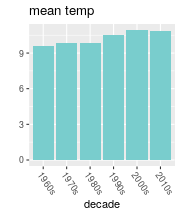

In [39]:
%%R -w2.5 -h3 -uin -i df2

ggplot(data=df2) +
    geom_bar(aes(x=decade, y=temp), stat='identity', fill='darkslategray3') +
    ylab('') + ggtitle('mean temp') +
    theme(axis.text.x = element_text(angle = -55, hjust = 0))

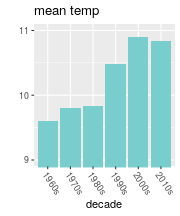

In [40]:
%%R -w2.5 -h3 -uin -i df2

ggplot(data=df2) +
    geom_bar(aes(x=decade, y=temp), stat='identity', fill='darkslategray3') +
    coord_cartesian(ylim=c(9,11)) +
    scale_y_continuous(breaks=c(9,10,11)) +
    ylab('') + ggtitle('mean temp') +
    theme(axis.text.x = element_text(angle = -55, hjust = 0))

In [47]:
# Traffic Speeds (mph) in Central London, major roads,
# Average Weekday between 7.00am and 7.00pm by Quarter
# http://content.tfl.gov.uk/street-performance-report-quarter2-2017-2018.pdf

import io

speed = pandas.read_csv(io.StringIO("""\
quarter,year,mph
q1,2014,8.69968262197242
q1,2015,7.77705247274574
q1,2016,7.65326766600704
q1,2017,7.44492247841471
q2,2014,9.21489506083079
q2,2015,8.08202304257207
q2,2016,7.70555811958787
q2,2017,7.91827621161064
q3,2014,8.38483350298095
q3,2015,7.71411952886433
q3,2016,7.29613835658876
q4,2014,8.81487967663689
q4,2015,8.52284342051746
q4,2016,8.02077603774818
"""))

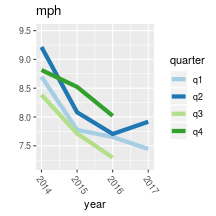

In [49]:
%%R -w3 -h3 -uin -ispeed

ggplot(data=speed) +
    geom_line(aes(x=year, y=mph, colour=quarter), size=2) +
    coord_cartesian(ylim=c(7.2,9.5)) +
    scale_colour_brewer(type='qual', palette='Paired') +
    ylab('') + ggtitle('mph') +
    theme(axis.text.x = element_text(angle=-55, hjust=0))

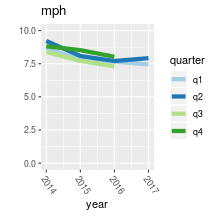

In [51]:
%%R -w3 -h3 -uin -ispeed

ggplot(data=speed) +
    geom_line(aes(x=year, y=mph, colour=quarter), size=2) +
    coord_cartesian(ylim=c(0,10)) +
    scale_colour_brewer(type='qual', palette='Paired') +
    ylab('') + ggtitle('mph') +
    theme(axis.text.x = element_text(angle=-55, hjust=0))

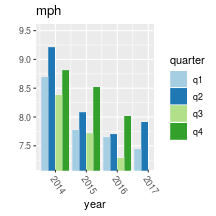

In [53]:
%%R -w3 -h3 -uin -ispeed

ggplot(data=speed) +
    geom_bar(aes(x=year, y=mph, fill=quarter), colour='white', size=.1, position=position_dodge(preserve='single'), stat='identity') +
    coord_cartesian(ylim=c(7.2,9.5)) +
    scale_fill_brewer(type='qual', palette='Paired') +
    ylab('') + ggtitle('mph') +
    theme(axis.text.x = element_text(angle=-55, hjust=0))

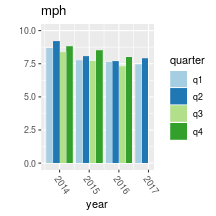

In [55]:
%%R -w3 -h3 -uin -ispeed

ggplot(data=speed) +
    geom_bar(aes(x=year, y=mph, fill=quarter), colour='white', size=.1, position=position_dodge(preserve='single'), stat='identity') +
    coord_cartesian(ylim=c(0,10)) +
    ylab('') + ggtitle('mph') +
    scale_fill_brewer(type='qual', palette='Paired') +
    theme(axis.text.x = element_text(angle=-55, hjust=0))

# 1. Geoms and aesthetic scales

In [56]:
url = 'https://teachingfiles.blob.core.windows.net/datasets/iris.csv'
iris = pandas.read_csv(url)

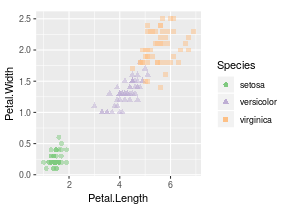

In [57]:
%%R -w4 -h3 -uin

ggplot(data=iris) +
    geom_point(aes(x=Petal.Length, y=Petal.Width, col=Species, shape=Species), alpha=.5, size=2) +
    guides(colour = guide_legend(override.aes=list(alpha=1))) +
    scale_colour_brewer(type='qual') +
    theme(aspect.ratio=1)

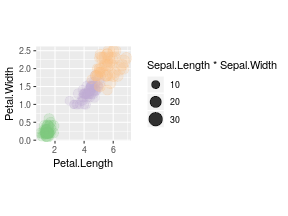

In [59]:
%%R -w4 -h3 -uin

ggplot(data=iris) +
    geom_point(aes(x=Petal.Length, y=Petal.Width, col=Species, size=Sepal.Length*Sepal.Width), alpha=.2) +
    scale_size_area(breaks=c(10,20,30)) +
    guides(colour = FALSE, size = guide_legend(override.aes=list(col='black',alpha=.8))) +
    scale_colour_brewer(type='qual') +
    theme(aspect.ratio=1)

In [69]:
iris['id'] = np.arange(len(iris))
df = pandas.melt(iris, id_vars=['id','Species'])
df = df.loc[df.variable.isin(['Sepal.Length','Sepal.Width'])]

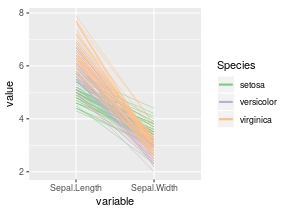

In [70]:
%%R -w4 -h3 -uin -i df

ggplot(data=df) +
    geom_line(aes(x=variable, y=value, col=Species, group=id), size=.2, alpha=.9) +
    scale_colour_brewer(type='qual') +
    guides(colour = guide_legend(override.aes=list(alpha=1,size=1))) +
    theme(aspect.ratio=1)

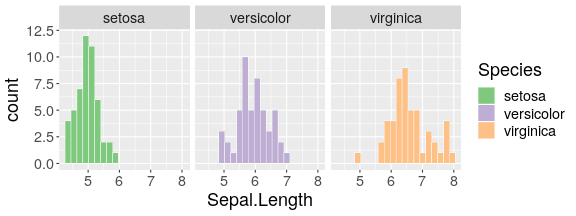

In [82]:
%%R -w8 -h3 -uin -i iris

ggplot(data=iris) +
    geom_bar(aes(x=Sepal.Length, fill=Species), stat='bin', bins=20, col='white', size=.2) +
    facet_wrap(~Species) +
    scale_fill_brewer(type='qual') +
    theme(text=element_text(size=18))

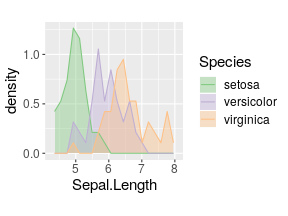

In [84]:
%%R -w4 -h3 -uin -i iris

ggplot(data=iris) +
    geom_area(aes(x=Sepal.Length, y=..density.., fill=Species), position='identity', stat='bin', alpha=.4, bins=20) +
    geom_line(aes(x=Sepal.Length, y=..density.., col=Species), stat='bin', bins=20) +
    scale_fill_brewer(type='qual') +
    scale_colour_brewer(type='qual') +
    theme(aspect.ratio=1, text=element_text(size=15))

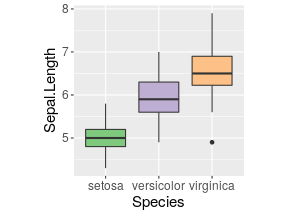

In [86]:
%%R -w4 -h3 -uin -i iris

ggplot(data=iris) + 
    geom_boxplot(aes(x=Species, y=Sepal.Length, fill=Species)) +
    scale_fill_brewer(type='qual', guide=FALSE) +
    theme(aspect.ratio=1, text=element_text(size=15))

# 3. Scale perception

In [88]:
n = 50
df = pandas.DataFrame({
    'x': np.random.uniform(size=n),
    'y': np.random.uniform(size=n),
    'a': np.random.permutation(n)==0,
    'b': np.random.permutation(n)==0,
    'c': np.random.permutation(n)==0,
    'd': np.random.binomial(size=n, n=6, p=.5)
})

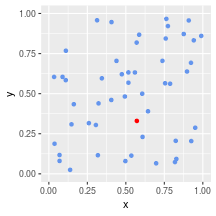

In [91]:
%%R -w3 -h3 -uin -i df

ggplot(data=df) +
    geom_point(aes(x=x, y=y, col=a)) +
    scale_colour_manual(values=c('TRUE'='red', 'FALSE'='cornflowerblue')) +
    coord_cartesian(xlim=c(0,1), ylim=c(0,1), expand=TRUE) +
    theme(legend.position='none')

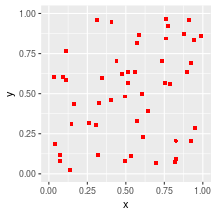

In [94]:
%%R -w3 -h3 -uin -i df

ggplot(data=df) +
    geom_point(aes(x=x, y=y, shape=b), col='red') +
    scale_shape_manual(values=c('TRUE'=16, 'FALSE'=15)) +
    coord_cartesian(xlim=c(0,1), ylim=c(0,1), expand=TRUE) +
    theme(legend.position='none')

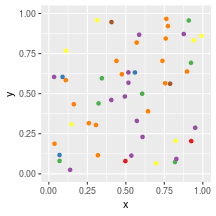

In [95]:
%%R -w3 -h3 -uin -i df

ggplot(data=df) +
    geom_point(aes(x=x, y=y, col=factor(d))) +
    scale_colour_brewer(type='qual', palette='Set1') +
    coord_cartesian(xlim=c(0,1), ylim=c(0,1), expand=TRUE) +
    theme(legend.position='none')

In [103]:
import sklearn.linear_model

url = 'https://teachingfiles.blob.core.windows.net/datasets/climate.csv'
climate = pandas.read_csv(url)
climate['temp'] = (climate.tmin + climate.tmax) / 2
climate['t'] = climate.yyyy + (climate.mm - 1) / 12
df = climate.loc[(climate.station=='Cambridge') & (~pandas.isnull(climate.temp)),
                ['t','temp']]

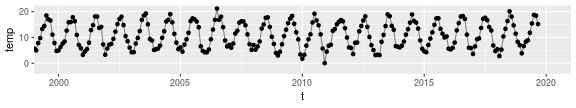

In [109]:
%%R -w8 -h1.5 -uin -i df

ggplot(data=df) +
    geom_line(aes(x=t, y=temp), col=gray(.5)) +
    geom_point(aes(x=t, y=temp)) +
    scale_x_continuous(breaks=seq(2000,2020,by=5)) +
    scale_y_continuous(breaks=c(0,10,20)) +
    coord_cartesian(xlim=c(2000,2020))

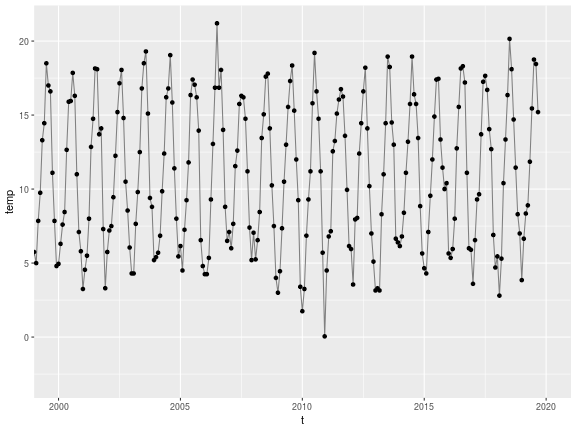

In [110]:
%%R -w8 -h6 -uin -i df

ggplot(data=df) +
    geom_line(aes(x=t, y=temp), col=gray(.5)) +
    geom_point(aes(x=t, y=temp)) +
    scale_x_continuous(breaks=seq(2000,2020,by=5)) +
    coord_cartesian(xlim=c(2000,2020))

# 4. Making comparisons

In [125]:
# Predictive accuracy of various ML classifiers on data from 10 patients.
# Data is copied from a talk at Addenbrookes.

import io

scans = pandas.read_csv(io.StringIO("""\
patient,gtv,lasso,owl,crl
p1, 0.281, 0.237, 0.268, 0.238
p2, 0.289, 0.228, 0.28,  0.228
p3, 0.291, 0.197, 0.28,  0.197
p4, 0.279, 0.207, 0.279, 0.208
p5, 0.291, 0.207, 0.28,  0.207
p6, 0.239, 0.197, 0.239, 0.197
p7, 0.301, 0.209, 0.28,  0.209
p8, 0.281, 0.208, 0.27,  0.208
p9, 0.25,  0.25,  0.26,  0.25
p10, 0.27, 0.229, 0.292, 0.229
"""))
scans = pandas.melt(scans, id_vars='patient', var_name='method', value_name='accuracy')

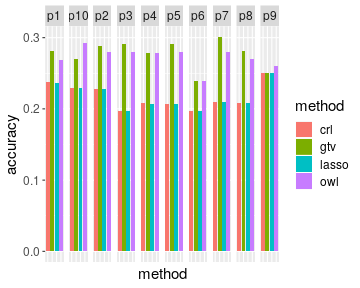

In [126]:
%%R -w5 -h4 -uin -i scans

ggplot(data=scans) +
    geom_bar(aes(x=method, fill=method, y=accuracy), stat='identity') +
    facet_grid(~patient) +
    theme(text=element_text(size=15), axis.text.x=element_blank(), axis.ticks.x=element_blank())

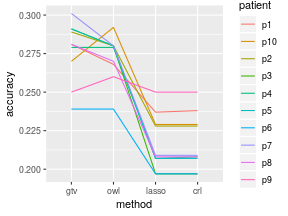

In [127]:
%%R -w4 -h3 -uin -i scans

scans$method <- factor(scans$method, levels=c('gtv','owl','lasso','crl'))

ggplot(data=scans) +
    geom_line(aes(x=method, y=accuracy, group=patient, col=patient), stat='identity')

# 5. Atomic plots

In [128]:
url = 'https://teachingfiles.blob.core.windows.net/datasets/mpg.csv'
mpg = pandas.read_csv(url)

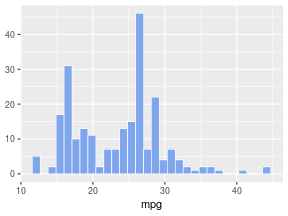

In [130]:
%%R -w4 -h3 -uin -i mpg

ggplot(data=mpg) + 
    geom_histogram(aes(x=hwy), bins=30, fill='cornflowerblue', alpha=.8, col='white', size=.3) + 
    xlab('mpg') + ylab(NULL)

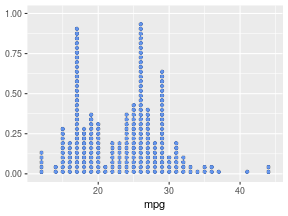

In [132]:
%%R -w4 -h3 -uin -i mpg

ggplot(data=mpg) + 
    geom_dotplot(aes(x=hwy), binwidth=.7, fill='cornflowerblue', stroke=.2, dotsize=.8, stackratio=1.2) +
    xlab('mpg') + ylab(NULL)

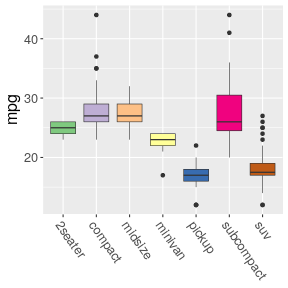

In [136]:
%%R -w4 -h4 -uin -i mpg

ggplot(mpg) + 
    geom_boxplot(aes(x=class, y=hwy, fill=class), size=.3) +
    xlab(NULL) + ylab('mpg') +
    scale_fill_brewer(type='qual') +
    guides(fill=FALSE) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=-55, hjust=0))

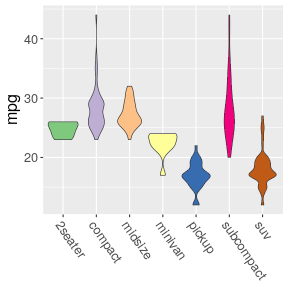

In [138]:
%%R -w4 -h4 -uin -i mpg

ggplot(mpg) +
    geom_violin(aes(x=class, y=hwy, fill=class), size=.3) + 
    xlab(NULL) + ylab('mpg') +
    theme(axis.text.x = element_text(angle = -55, hjust = 0)) +
    scale_fill_brewer(type='qual') +
    guides(fill=FALSE) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=-55, hjust=0))

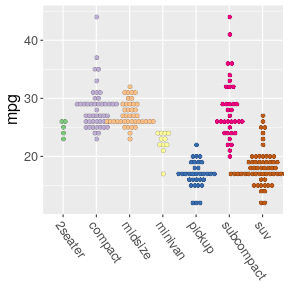

In [139]:
%%R -w4 -h4 -uin -i mpg

ggplot(data=mpg) + 
    geom_dotplot(aes(x=class, y=hwy, fill=class), binwidth=.7, binaxis='y', stroke=.2, dotsize=1.1, stackratio=0.8, stackdir='center') +
    xlab(NULL) + ylab('mpg') +
    scale_fill_brewer(type='qual') +
    guides(fill=FALSE) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=-55, hjust=0))